## Employment Opportunities for Persons with Disabilities

In [1]:
# Import preliminaries
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('axes', edgecolor='lightgray')
plt.rc('ytick',labelsize=8)
plt.rc('xtick',labelsize=8)
import itertools, os
from pathlib import Path

# Seasonal Adjustment Tools
os.environ['X13PATH'] = '/home/brian/Documents/econ_data/micro/x13as/'
import statsmodels.api as sm
from statsmodels.tsa.x13 import x13_arima_analysis

# bd CPS files
cps_dir = Path('/home/brian/Documents/CPS/data/clean/')

# Functions
def dis_rate(df, query=None, seasadj=True, weight='BASICWGT'):
    '''
    Return disability rate for dataframe and query
    '''
    groups = ['YEAR', 'MONTH', 'NILFREASON']
    if query != None:
        df = df.query(query)
    res = df.groupby(groups)[weight].sum().unstack()
    res = res[res > 0].dropna()
    s = (res['Disabled/Ill'] / res.sum(axis=1)) * 100
    s.index = pd.to_datetime([f'{yr}-{mo}-01' for yr, mo in s.index])
    if seasadj != False:
        s = x13_arima_analysis(s).seasadj
        
    return s

# Recession start and end months, from NBER
rec_dt = [('1969-12-01', '1970-11-01'), ('1973-11-01', '1975-03-01'), 
          ('1980-01-01', '1980-07-01'), ('1981-07-01', '1982-11-01'),
          ('1990-07-01', '1991-03-01'), ('2001-04-01', '2001-12-01'), 
          ('2008-01-01', '2009-07-01'), ('2020-02-01', '2020-04-01')]


# Function to retrieve a series from FRED
def fred_df(series):
    url = f'http://research.stlouisfed.org/fred2/series/{series}/downloaddata/{series}.csv'
    df = pd.read_csv(url, index_col='DATE', parse_dates=True, na_values=['.'])
    return df.rename({'VALUE': series}, axis=1)

In [2]:
# Get CPS data
cols = ['YEAR', 'MONTH', 'FEMALE', 'AGE', 'NILFREASON', 
        'LFS', 'BASICWGT', 'CPSID', 'LINENO', 'WBHAO']

df1 = pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=cols)
                for year in range(1994, 2008)])

# Disability Data starts in 2008
cols = cols + ['DISABILITY']
df2 = pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=cols)
                 for year in range(2008, 2024)])

df = pd.concat([df1, df2])

# Federal Retirement Age Varies by Birth Year
df['YOB'] = df['YEAR'] - df['AGE']
df['FRA'] = (np.where(df.YOB <= 1937, 65, 
             np.where(df.YOB <= 1954, 66, 67)))

# Date from Year, Month
df['DATE'] = pd.to_datetime(dict(year=df.YEAR, 
                                 month=df.MONTH, day=1))

# Demographically-adjusted weight
dates = ['DATE']
dems = ['FEMALE', 'AGE']
wgt = 'BASICWGT'

p = df.groupby(dates + dems)[wgt].sum().rename('ADJ')
sh = (p / p.groupby(dates).sum()).dropna()
adj = (sh.loc['1994-01-01'] / sh).reset_index()
data = (pd.merge(df, adj)
          .assign(ADJWGT = lambda x: x.ADJ * x[wgt]))
data['NILFREASON'] = data.NILFREASON.cat.rename_categories({'nan': 'LF'})

raw = data

### Chart 1 - Overview 

In [3]:
# Chart 1 Data
# NILF - Disability, Sum, if below Federal Retirement Age (FRA)
query = 'AGE < FRA'
groups = ['DATE', 'NILFREASON']
data = raw
res = data.query(query).groupby(groups).BASICWGT.sum().unstack()
res = res[res > 0].dropna()
tot = res['Disabled/Ill'] / 1_000_000
tot.index = pd.to_datetime(tot.index)
tot.to_csv('NILF_Dis_Level.csv', index_label='date')

# Beneficiary data from SSA
url = 'https://www.ssa.gov/oact/STATS/OASDIbenies.html'
tbl = pd.read_html(url)[2]
tbl.columns = tbl.loc[2]
tbl = tbl.loc[3:, ['Year', 'Disabled workers and dependents']]
tbl = tbl.iloc[:-2]
tbl.index = pd.to_datetime([f'{y}-12-31' for y in tbl.Year])
tbl.index.name = ''
s = tbl['Disabled workers and dependents'].astype('int') / 1_000_000
s.name = 'SSDI'
s.to_csv('SSDI_beneficiaries.csv', index_label='date')

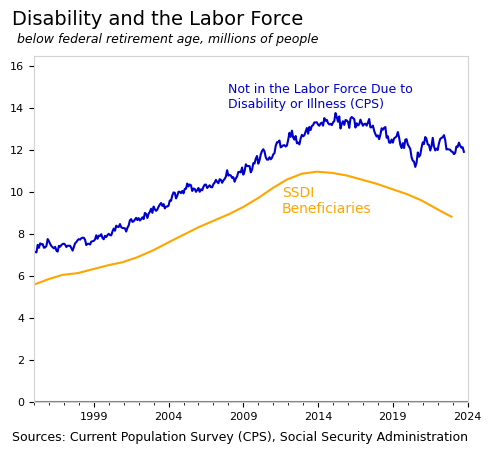

In [4]:
# Create Chart
tot = pd.read_csv('NILF_Dis_Level.csv', index_col='date', 
                  parse_dates=True)
tot.index.name = ''
s = pd.read_csv('SSDI_beneficiaries.csv', index_col='date', 
                  parse_dates=True)
s.index.name = ''
fig, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()
tot.plot(ax=ax, color='mediumblue', legend=False)
s = s.resample('M').interpolate()
s.loc['1994':].plot(ax=ax, color='orange', legend=False)
ssditxt = 'SSDI\nBeneficiaries'
ax.text('2011-08-01', 9, ssditxt, color='orange', size=10)
cpstxt = ('Not in the Labor Force Due to \n'+
          'Disability or Illness (CPS)')
ax.text('2008-01-01', 14, cpstxt, color='mediumblue', size=9)
ax.set_ylim(0, 16.5)
ax.set_xlim('1995-01-01', '2024-01-01')
fig.text(0.04, 1.03, 'Disability and the Labor Force', size=14)
subtitle = 'below federal retirement age, millions of people'
fig.text(0.05, 0.985, subtitle, size=9, style='italic')
footer = ('Sources: Current Population Survey (CPS), Social '+
          'Security Administration')
fig.text(0.04, -0.01, footer, size=9)
ax.axhline(0, zorder=0, color='gray')
plt.savefig('chart1.png', bbox_inches='tight')
plt.show()

### Chart 2 - Demographics

In [5]:
# Chart 2 Disability Rates
data = raw
dem = pd.DataFrame()
# NILF - Disability, Rate, Unadjusted Age 16 + 
query = 'AGE >= 16'
dem['tot_rt'] = dis_rate(data, query=query)
dem['tot_rt_adj'] = dis_rate(data, query=query, weight='ADJWGT')

# Age 16 to 35
query = 'AGE >= 16 and AGE <= 35'
dem['u35_rt'] = dis_rate(data, query=query)
dem['u35_rt_adj'] = dis_rate(data, query=query, weight='ADJWGT')

dem.to_csv('NILF_Dis_Rate.csv', index_label='date')

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


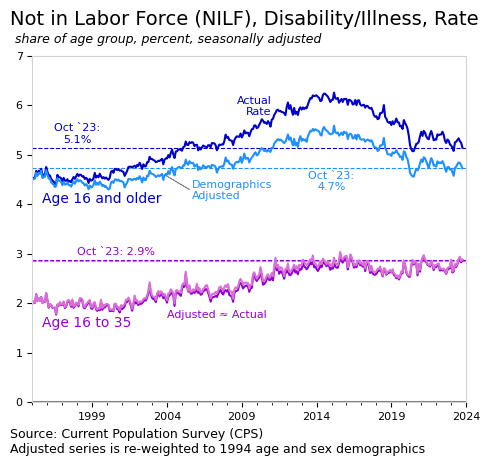

In [6]:
# Chart 2 - Create chart
dem = pd.read_csv('NILF_Dis_Rate.csv', index_col='date', 
                  parse_dates=True)
dem.index.name = ''

fig, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()
dem['tot_rt'].plot(ax=ax, color='mediumblue')
dem['tot_rt_adj'].plot(ax=ax, color='dodgerblue')
dem['u35_rt'].plot(ax=ax, color='darkviolet')
dem['u35_rt_adj'].plot(ax=ax, color='orchid')

ltdt = dem['tot_rt'].index[-1].strftime('%b `%y')
ltval_adj = dem['tot_rt_adj'].iloc[-1]
ltval_act = dem['tot_rt'].iloc[-1]
ltval_u35 = dem['u35_rt_adj'].iloc[-1]

# Settings
ax.set_ylim(0, 7)
ax.set_xlim('1995-01-01', '2024-01-01')
fig.text(0.04, 1.03, 'Not in Labor Force (NILF), Disability/Illness, Rate', size=14)
subtitle = 'share of age group, percent, seasonally adjusted'
fig.text(0.05, 0.985, subtitle, size=9, style='italic')
footer = ('Source: Current Population Survey (CPS)\n'+
          'Adjusted series is re-weighted to 1994 age and sex demographics')
fig.text(0.04, -0.04, footer, size=9)
ax.axhline(0, zorder=0, color='lightgray', lw=1)
ax.axhline(dem['tot_rt_adj'].iloc[-1], zorder=0, color='dodgerblue', 
           lw=0.8, linestyle='--')
ax.axhline(dem['tot_rt'].iloc[-1], zorder=0, color='mediumblue', 
           lw=0.8, linestyle='--')
ax.axhline(dem['u35_rt'].iloc[-1], zorder=0, color='orchid', 
           lw=0.8, linestyle='--')
ax.axhline(dem['u35_rt_adj'].iloc[-1], zorder=0, color='darkviolet', 
           lw=0.8, linestyle='--')
ax.text('1995-09-01', 4.02, 'Age 16 and older', color='mediumblue', size=10)
ax.text('1995-09-01', 1.52, 'Age 16 to 35', color='darkviolet', size=10)
plt.arrow('2003-11-01',4.6,20,-0.3, lw=0.5, color='gray')
ax.text('2005-09-01', 4.1, 'Demographics\nAdjusted', color='dodgerblue', size=8)
ax.text('2015-01-01', ltval_adj - 0.05, f'{ltdt}:\n{ltval_adj:.1f}%', 
        color='dodgerblue', size=8, va='top', ha='center')
ax.text('1998-01-01', ltval_act + 0.05, f'{ltdt}:\n{ltval_act:.1f}%', 
        color='mediumblue', size=8, va='bottom', ha='center')
ax.text('1998-01-01', ltval_u35 + 0.05, f'{ltdt}: {ltval_u35:.1f}%', 
        color='darkviolet', size=8, va='bottom')
ax.text('2011-01-01', 5.8, 'Actual\nRate', color='mediumblue', 
        size=8, ha='right')
ax.text('2004-01-01', 1.7, 'Adjusted ≈ Actual', color='darkviolet', 
        size=8, ha='left')
ax.axhline(0, zorder=0, color='gray')
plt.savefig('chart2.png', bbox_inches='tight')
plt.show()

### Chart 3 - Jobfinding

In [7]:
# Chart 3 - Flow, Disability to Work
emp = lambda x: np.where(x.LFS_y == 'Employed', 1, 0)
emprt = lambda x: np.average(x.EMP, weights=x.BASICWGT_y) * 100
emprtadj = lambda x: np.average(x.EMP, weights=x.ADJWGT_y) * 100

ml = ['DATE', 'CPSID', 'LINENO', 'FEMALE', 'WBHAO']
oth = ['LFS', 'BASICWGT', 'ADJWGT', 'AGE']

data = raw
data2 = data.copy()
data2['DATE'] = data2['DATE'] + pd.DateOffset(years=1)
data2['YEAR'] = data2['YEAR'] + 1

# Memory constraints, split by year:
res = pd.DataFrame()
for year in range(1997, 2024):
    dft1 = data2.query('YEAR == @year and NILFREASON == "Disabled/Ill"')[ml + oth]
    dft2 = data.query('YEAR == @year')[ml + oth]
    dfm = (pd.merge(dft1, dft2, on=ml))
    dfm = ((dfm.loc[(dfm.AGE_x <= dfm.AGE_y) & 
                    (dfm.AGE_y - 2 <= dfm.AGE_x)])
               .assign(EMP = emp))
    res = pd.concat([res, dfm])
res = res.query('AGE_y >= 16')

# Store results
jfr = pd.DataFrame()
jfr['Age16plus'] = res.groupby('DATE').apply(emprt)
jfr['Age16plusADJ'] = res.groupby('DATE').apply(emprtadj)
jfr.to_csv('Jobfinding.csv', index_label='date')

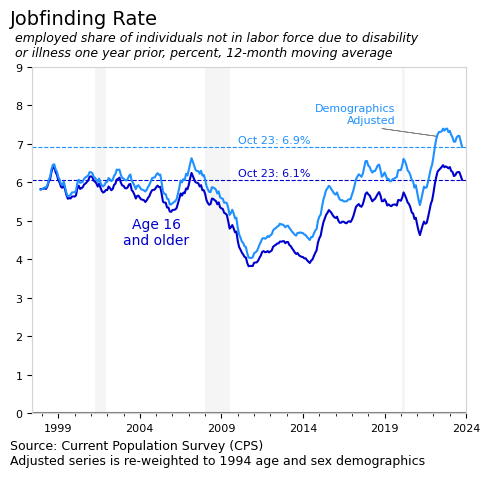

In [8]:
# Create Chart
res = pd.read_csv('Jobfinding.csv', index_col='date', 
                  parse_dates=True)
res.index.name = ''
fig, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()
d12 = res.rolling(12).mean()
d12['Age16plus'].plot(color='mediumblue', ax=ax)
d12['Age16plusADJ'].plot(color='dodgerblue', ax=ax)

# Recession bars
for r_start, r_end in rec_dt:
    ax.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)

ax.set_ylim(0, 9)
ax.set_xlim('1997-06-01', '2024-01-01')
ax.text('2005-01-01', 4.4, 'Age 16\nand older', color='mediumblue', 
        size=10, ha='center')

# Mark latest values
ltdt = d12.index[-1].strftime('%b %y')
lttot = d12['Age16plus'].iloc[-1]
ltadj = d12['Age16plusADJ'].iloc[-1]
ax.axhline(lttot, zorder=0, color='mediumblue', 
           lw=0.8, linestyle='--')
ax.text('2010-01-01', lttot + 0.05, f'{ltdt}: {lttot:.1f}%', 
        color='mediumblue', size=8, va='bottom', ha='left')
ax.axhline(ltadj, zorder=0, color='dodgerblue', 
           lw=0.8, linestyle='--')
ax.text('2010-01-01', ltadj + 0.05, f'{ltdt}: {ltadj:.1f}%', 
        color='dodgerblue', size=8, va='bottom', ha='left')
plt.arrow('2022-03-01',7.2,-40,0.2, lw=0.5, color='gray')
ax.text('2019-09-01', 7.55, 'Demographics\nAdjusted', color='dodgerblue', 
        size=8, ha='right')
ax.axhline(0, zorder=0, color='gray')

# Title and footer
fig.text(0.04, 1.06, 'Jobfinding Rate', size=14)
subtitle = ('employed share of individuals not in labor force due to '+
            'disability\nor illness one year prior, percent, '+
            '12-month moving average')
fig.text(0.05, 0.98, subtitle, size=9, style='italic')
footer = ('Source: Current Population Survey (CPS)\n'+
          'Adjusted series is re-weighted to 1994 age and sex demographics')
fig.text(0.04, -0.04, footer, size=9)
plt.savefig('chart3.png', bbox_inches='tight')
plt.show()

### Chart 4 - Employment Rate

In [9]:
# Chart 4 - Employment Rate

# Retrieve series from FRED for comparison
#bls = fred_df('LNU02374597')
#bls = bls.rename({'VALUE': 'BLS'}, axis=1)

# CPS data
data = raw
d = {'Tot': ('AGE >= 16 and DISABILITY == 1', 'BASICWGT'),
     'TotAdj': ('AGE >= 16 and DISABILITY == 1', 'ADJWGT'),
     'Age1635': ('16 <= AGE <= 35 and DISABILITY == 1', 'BASICWGT')}
res = pd.DataFrame()

# Employment rate for each age group
for name, (query, wgt) in d.items():
    df = raw.query(query)
    s = ((df.groupby(['DATE', 'LFS'])[wgt].sum() / 
          df.groupby('DATE')[wgt].sum() * 100)
            .unstack()['Employed'].dropna())
    res[name] = x13_arima_analysis(s).seasadj
res.to_csv('Employment_Rate.csv', index_label='date')    
#res.index.name = ''

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


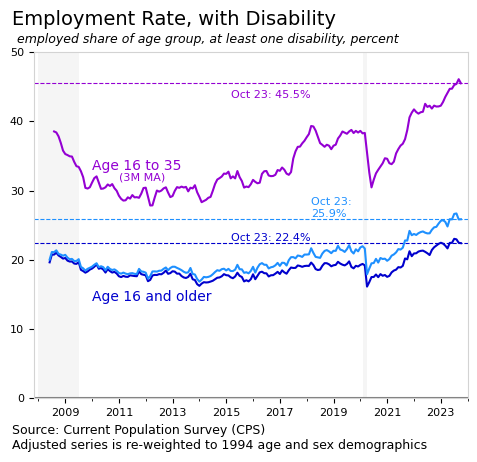

In [10]:
# Create Chart
res = pd.read_csv('Employment_Rate.csv', index_col='date', 
                  parse_dates=True)
res.index.name = ''
fig, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()
res['Tot'].plot(ax=ax, color='mediumblue')
res['TotAdj'].plot(ax=ax, color='dodgerblue')
a1635 = res['Age1635'].rolling(3).mean()
res['Age1635'].rolling(3).mean().plot(ax=ax, color='darkviolet')
# Recession bars
for r_start, r_end in rec_dt:
    ax.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)

# Annotations
ax.text('2010-01-01', 14, 'Age 16 and older', color='mediumblue', size=10)
ax.text('2010-01-01', 33.0, 'Age 16 to 35', color='darkviolet', size=10)
ax.text('2011-01-01', 31.4, '(3M MA)', color='darkviolet', size=8)
ax.axhline(res.TotAdj.iloc[-1], zorder=0, color='dodgerblue', 
           lw=0.8, linestyle='--')
ax.text('2018-03-01', res.TotAdj.iloc[-1] + 0.05,
        f'{ltdt}:\n{res.TotAdj.iloc[-1]:.1f}%', 
        color='dodgerblue', size=8, va='bottom', ha='left')
ax.axhline(res.Tot.iloc[-1], zorder=0, color='mediumblue', 
           lw=0.8, linestyle='--')
ax.text('2015-03-01', res.Tot.iloc[-1] + 0.05,
        f'{ltdt}: {res.Tot.iloc[-1]:.1f}%', 
        color='mediumblue', size=8, va='bottom', ha='left')

ax.axhline(a1635.iloc[-1], zorder=0, color='darkviolet', 
           lw=0.8, linestyle='--')
ax.text('2015-03-01', a1635.iloc[-1] - 0.9,
        f'{ltdt}: {a1635.iloc[-1]:.1f}%', 
        color='darkviolet', size=8, va='top', ha='left')
    
# Settings
ax.set_ylim(0, 50)
ax.set_xlim('2007-11-01', '2024-01-01')
ax.axhline(0, zorder=0, color='gray')

# Title and footer
fig.text(0.04, 1.02, 'Employment Rate, with Disability', size=14)
subtitle = ('employed share of age group, at least one disability, percent')
fig.text(0.05, 0.975, subtitle, size=9, style='italic')
footer = ('Source: Current Population Survey (CPS)\n'+
          'Adjusted series is re-weighted to 1994 age and sex demographics')
fig.text(0.04, -0.04, footer, size=9)
plt.savefig('chart4.png', bbox_inches='tight')
plt.show()

### Chart 5 - Disability Rates

In [11]:
# Chart 5 - Get Data
groups = {'A1635': ('AGE >=16 and AGE <= 35', 'BASICWGT'),
          'A3654': ('AGE >= 36 and AGE <= 54', 'BASICWGT'), 
          'A55': ('AGE >= 55', 'BASICWGT'), 
          'TOT': ('AGE >=16', 'BASICWGT'),
          'TOTADJ': ('AGE >=16', 'ADJWGT')}
rt = pd.DataFrame()
#num = pd.DataFrame()
for name, (query, wgt) in groups.items():
    r1 = data.query(query).groupby(['DATE', 'DISABILITY'])[wgt].sum()
    r2 = data.query(query).groupby(['DATE'])[wgt].sum()
    rt[name] = ((r1 / r2).unstack()[1]).dropna()
    #num[name] = r1.unstack()[1]
rt.to_csv('Disability_Rate.csv', index_label='date')

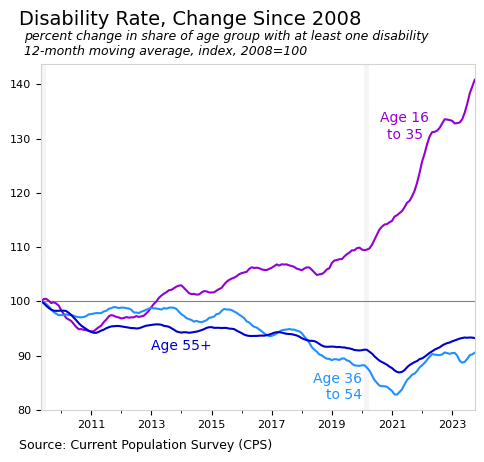

In [12]:
# Chart 5 - Create Chart
rt = pd.read_csv('Disability_Rate.csv', index_col='date', 
                  parse_dates=True)
rt.index.name = ''
fig, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()
rest = rt[rt > 0].rolling(12).mean().dropna()
ch_idx = ((rest / rest.iloc[0])[['A1635', 'A3654', 'A55']] * 100)
ch_idx.index.name = ''
colors=['darkviolet', 'dodgerblue', 'mediumblue']
ch_idx[['A1635', 'A3654', 'A55']].plot(ax=ax, color=colors, legend=False)
# Recession bars
for r_start, r_end in rec_dt:
    ax.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
    
# Annotations
ax.axhline(100, zorder=0, lw=0.8, color='gray')
ax.text('2020-01-01', 82, 'Age 36\nto 54', color='dodgerblue', 
        size=10, ha='right')
ax.text('2021-06-01', 130, 'Age 16\nto 35', color='darkviolet', 
        size=10, ha='center')
ax.text('2013-01-01', 91, 'Age 55+', color='mediumblue', 
        size=10, ha='left')
# Title and footer
fig.text(0.04, 1.05, 'Disability Rate, Change Since 2008', size=14)
subtitle = ('percent change in share of age group with at least one '+
            'disability\n12-month moving average, index, 2008=100')
fig.text(0.05, 0.975, subtitle, size=9, style='italic')
footer = ('Source: Current Population Survey (CPS)')
fig.text(0.04, -0.01, footer, size=9)
plt.savefig('chart5.png', bbox_inches='tight')
plt.show()